# Underfloor Heating


## Background

In a district heating network, the heat generated by producing plant is distributed to consumer as heated supply water for underfloor heating purpose. After the heat has been utilized for room heating, the water at a lower temperature is circulated back to the district heating plant. The water circulates in a closed pipeline.

Combined heat and power plant is efficient because the steam generated can be used to generate electricity via gas turbine, and the heat can also be transferred to a district heating network via heat exchanger to reduce heat waste. 


## Problem Formulation

In this use case, we are looking at controlling room temperature using underfloor heating by adjusting the amount of heating water flowing through the underfloor pipe.

During winter time, in order to keep the room temperature at optimal comfort level setpoint, say 21 degree Celsius, the amount return water temperature flow rate is adjusted by microcontroller dynamically based on the return water temperature, room temperature and other external variables. The higher the heated water flow rate, the higher the amount of heat transfer to the room.

Optimal comfort temperature: This is the preferred room temperature which can be set on the thermostat. This varies from person-to-person, but generally 21°C is the ideal temperature for living areas.

**Objective:**

To identify return water temperature setpoints to achieve optimal energy consumption and comfort level.

**Gym Environment**

A gym environment has also been built to evaluate whatif model performance and compared against other RL agents.

States:

- room_temperature
- outside_temperature
- outside_humidity
- sin_time
- cos_time
- sin_week
- cos_week

Actions:

- return_water_temp_setpoint

Rewards:

- Deviation from optimal comfort temperature.





In [1]:
from pathlib import Path

import d3rlpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from underfloor_heating_gym_env import (
    UnderfloorEnv,
    UnderfloorEnvConfig,
    WhatifWrapperUnderfloor,
    cal_reward,
    create_features,
    get_data,
)
from utils import create_new_context, get_next_action, obs_to_wi_context, wi_context_to_token

import a2rl as wi
from a2rl.utils import plot_information

torch.manual_seed(99)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

## Data Ingestion

Before we start using A2RL, we want to first analyze the data to ensure there is markov property and variance in the data to train a simulator.


Load dataset.

In [2]:
df = get_data("underfloor_heating.csv")

Create addtional features such as sinusoidal time and week to capture seasonality and trend of time and year, and reward columns.

In [3]:
df = create_features(df)
df = cal_reward(df)

Create whatif dataframe by indicating the states, actions and rewards columns.

In [4]:
states = [
    "room_temperature",
    "outside_temperature",
    "supply_water_temp",
    "sin_time",
    "cos_time",
    "sin_week",
    "cos_week",
]
actions = ["return_water_temp_setpoint"]
rewards = ["reward"]

wi_df = wi.WiDataFrame(df, states=states, actions=actions, rewards=rewards)
wi_df[wi_df.sar].head(2)

,room_temperature,outside_temperature,supply_water_temp,sin_time,cos_time,sin_week,cos_week,return_water_temp_setpoint,reward
0,22.093343,-1.378907,34.607801,-0.707107,-0.707107,-0.568065,0.822984,30.378514,-0.546671
1,22.100753,0.167802,34.429965,-0.500000,-0.500000,-0.568065,0.822984,30.807954,-0.550377


In [5]:
wi_df[wi_df.states].describe()

,room_temperature,outside_temperature,supply_water_temp,sin_time,cos_time,sin_week,cos_week
count,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000
mean,21.651581,3.861973,35.440627,0.000157,0.000157,0.209152,0.481912
std,0.766997,6.253957,3.853844,0.706738,0.706738,0.601263,0.602282
min,19.717195,-9.282808,18.825758,-1.000000,-1.000000,-1.000000,-1.000000
25%,21.085140,-0.959127,33.599622,-0.707107,-0.707107,-0.239316,0.239316
50%,21.575938,2.969267,36.768509,0.000000,0.000000,0.239316,0.748511
75%,22.127457,7.299032,37.998968,0.707107,0.707107,0.748511,0.935016
max,24.134169,26.403440,41.212417,1.000000,1.000000,1.000000,1.000000


## Data Property Check

Perform data property check using `plot_information` function. We can see clearly based on whatif data analysis, there is markov properties with 1-2 lags, and there is relationship where the action will affect the states and rewards.

Test
Markov Order f(state,action)=> next_state    Lag_1
Reward Function f(state,action)=> reward     Lag_5
Action Contribution f(action)=> reward       Lag_1
Action Effectiveness f(action)=> state       Lag_1
dtype: object


<AxesSubplot:ylabel='Test'>

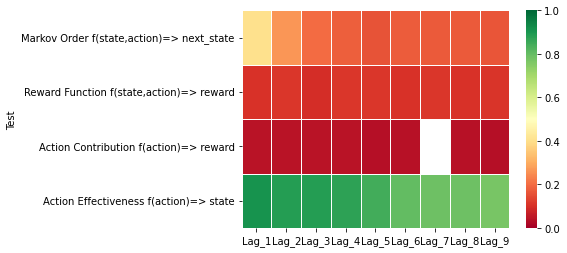

In [6]:
plot_information(wi_df)

## Train a A2RL model

Now let's start by training a A2RL model.

**Note:** It is recommended to run this tutorial on machine with GPU. It takes approximately 1.5 hour if run on CPU.


In [7]:
OUTPUT_DIR = Path("./model")
TRAIN_RATIO = 0.9
BLOCK_SIZE_ROW = 20

train_ratio = TRAIN_RATIO
train_range = int(train_ratio * df.shape[0])
wi_df = wi.WiDataFrame(df, states, actions, rewards)

df_train = wi_df.iloc[:train_range]
df_test = wi_df.iloc[train_range:]
print(f"{df_train.shape=}, {df_test.shape=}")

tokenizer = wi.AutoTokenizer(wi_df, block_size_row=BLOCK_SIZE_ROW, train_ratio=train_ratio)

df_train.shape=(2677, 13), df_test.shape=(298, 13)


/Users/yihyap/.pyenv/versions/3.10.4/envs/whatif/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/yihyap/.pyenv/versions/3.10.4/envs/whatif/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/yihyap/.pyenv/versions/3.10.4/envs/whatif/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/yihyap/.pyenv/versions/3.10.4/envs/whatif/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 ar

In [8]:
custom_config = {
    "train_config": {
        "epochs": 5,
        "batch_size": 512,
        "embedding_dim": 512,
        "gpt_n_layer": 1,
        "gpt_n_head": 1,
        "learning_rate": 0.0006,
        "num_workers": 8,
        "lr_decay": True,
    }
}

model_dir = OUTPUT_DIR
wrapper = wi.GPTBuilder(tokenizer, model_dir)

if (OUTPUT_DIR / "model.pt").exists():
    model = wrapper.load_model()
else:
    model = wrapper.fit()
simulator = wi.Simulator(tokenizer, model)

Now let's evaluate the trained A2RL by running one episode of the gym environment with 500 steps.

In [9]:
# Helper functions to transform data between a2rl and gym observation.
env_config = UnderfloorEnvConfig(episode_len=500, data_path="underfloor_heating.csv")
env = UnderfloorEnv(env_config)
env = WhatifWrapperUnderfloor(env)


reward_list = []
done = False
obs = env.reset()
context_df = obs_to_wi_context(tokenizer, obs)
context_tokenized = wi_context_to_token(tokenizer, context_df)

for i in range(1):
    done = False
    obs = env.reset()
    while not done:
        # Use whatif to get next best action
        recommendation_df = simulator.sample(context_tokenized, max_size=3, as_token=False)
        action = recommendation_df.iloc[recommendation_df.reward.idxmax(), 0]
        obs, reward, done, _ = env.step(action)

        # Update new context
        new_context_df = create_new_context(tokenizer, context_df, action, reward, obs)
        context_df = new_context_df

        context_tokenized = wi_context_to_token(tokenizer, new_context_df)
        reward_list.append(reward)

a2rl_total_reward = np.sum(reward_list)
print(f"Total reward: {a2rl_total_reward}")
a2rl_eval_df = env.df.reset_index(drop=True)

Total reward: -177.73760986328125


## Train CQL Model

Now we train another offline algorithm [Conservative Q-Learning for Offline Reinforcement Learning][1] (CQL) which will be used to compare wiht A2RL later.

[1]: https://arxiv.org/abs/2006.04779 

Prepare train/test dataset for d3rl.

In [10]:
df["terminal"] = 0
# Set every 100 as terminal state as d3rl required episode indicator.
df["terminal"] = np.where(df.index % 100 == 0, 1, 0)

dataset = d3rlpy.dataset.MDPDataset(
    observations=df[states].to_numpy(),
    actions=df[actions].to_numpy(),
    rewards=df[rewards].to_numpy(),
    terminals=df["terminal"].to_numpy(),
)
# Split rows without shuffle to closely align with training data used for A2RL model.
train_episodes, test_episodes = train_test_split(dataset, train_size=TRAIN_RATIO, shuffle=False)
print(len(train_episodes), len(test_episodes))

27 3


Train a d3rl model. If you are running on CPU, you need to set `use_gpu=True`.

In [11]:
d3rlpy.seed(0)

try:
    import os

    d3rl_path = Path("d3rlpy_logs")
    params_file = list(d3rl_path.glob("cql-*/params.json"))[-1]
    model_file = list(d3rl_path.glob("cql-*/model*.pt"))
    model_file = sorted(model_file, key=os.path.getmtime)[-1]
    print(f"Loading model: {model_file}")
    print(f"Loading param: {params_file}")
    cql = d3rlpy.algos.cql.CQL.from_json(params_file)
    cql.load_model(model_file)
    model_exist = True

except:
    print("No existing model found")
    model_exist = False

Look for existng model
Loading model: d3rlpy_logs/cql-epoch-300-ar-0.01-cr-0.1-t-0.0001_20220810162428/model_30.pt
Loading param: d3rlpy_logs/cql-epoch-300-ar-0.01-cr-0.1-t-0.0001_20220810162428/params.json
2022-08-16 15:11.10 [warning  ] Unused arguments are passed.   algorithm=CQL generated_maxlen=100000 real_ratio=1.0


In [12]:
%%capture
if not model_exist:
    n_epochs = 300
    actor_learning_rate = 1e-2
    critic_learning_rate = 1e-1
    temp_learning_rate = 1e-4

    cql = d3rlpy.algos.cql.CQL(
        actor_learning_rate=actor_learning_rate,
        critic_learning_rate=critic_learning_rate,
        temp_learning_rate=temp_learning_rate,
        scaler="min_max",
        action_scaler="min_max",
        reward_scaler="min_max",
        use_gpu=True,
    )
    cql.build_with_dataset(dataset)
    results = cql.fit(
        train_episodes,
        eval_episodes=test_episodes,
        n_epochs=n_epochs,
        experiment_name=f"cql-epoch-{n_epochs}-ar-{actor_learning_rate}-cr-{critic_learning_rate}-t-{temp_learning_rate}",
        logdir="d3rlpy_logs",
        verbose=False,
        tensorboard_dir="tb_logs",
    )

Please check with both the actor and critic loss to ensure the agent is learning.

In [13]:
# Only run when training a new model
if not model_exist:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    axes = ax.flatten()

    axes[0].plot([elem[1]["critic_loss"] for elem in results])
    axes[0].grid()
    axes[1].plot([elem[1]["actor_loss"] for elem in results])
    axes[1].grid()
    plt.tight_layout()
    plt.show()

Similarly, let's evaluate the trained d3rl by running one episode of the gym environment with 500 steps.

In [14]:
%%time
env_config = UnderfloorEnvConfig(episode_len=500, data_path="underfloor_heating.csv")
env = UnderfloorEnv(env_config)
env = WhatifWrapperUnderfloor(env)

reward_list = []
done = False
obs = env.reset()

for i in range(1):
    done = False
    obs = env.reset()
    while not done:
        # Use CQL agent to get next best action
        action = cql.predict(obs)
        # Take a step
        obs, reward, done, _ = env.step(action)
        # print(f"{action=}")
        reward_list.append(reward)

cql_total_reward = np.sum(reward_list)
print(f"Total reward: {cql_total_reward}")
cql_eval_df = env.df.reset_index(drop=True)

Total reward: -249.72195434570312
CPU times: user 549 ms, sys: 4.2 ms, total: 553 ms
Wall time: 559 ms


## Summary

After we trained the A2RL model, we performed evaluation over 500 episodes of the dataset to assess how well A2RL recommendation is doing. We compared against [Conservative Q-Learning for Offline Reinforcement Learning](https://arxiv.org/abs/2006.04779) (CQL), a offline RL algorithms.



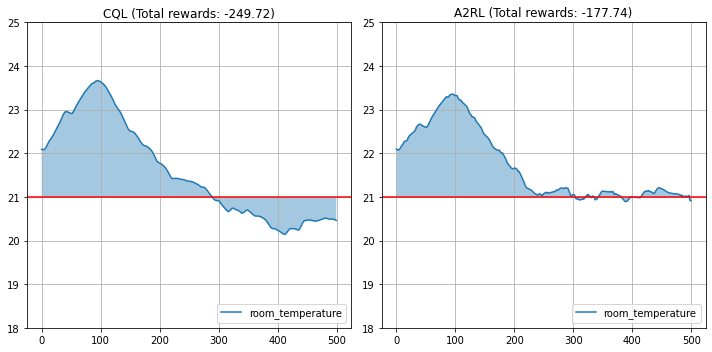

In [15]:
OPTIMAL_TEMP = 21

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
axes = ax.flatten()

f1 = cql_eval_df[["room_temperature"]].plot(
    title=f"CQL (Total rewards: {cql_total_reward:.02f})",
    ylim=(18, 25),
    grid=True,
    ax=axes[0],
)
f1.legend(loc="lower right")
f1.axhline(y=OPTIMAL_TEMP, color="r", linestyle="-")
f1.fill_between(
    range(len(cql_eval_df)),
    cql_eval_df[["room_temperature"]].values.flatten(),
    OPTIMAL_TEMP,
    step="pre",
    alpha=0.4,
)

f2 = a2rl_eval_df[["room_temperature"]].plot(
    title=f"A2RL (Total rewards: {a2rl_total_reward:.02f})",
    ax=axes[1],
    ylim=(18, 25),
    grid=True,
)
f2.legend(loc="lower right")
f2.axhline(y=OPTIMAL_TEMP, color="r", linestyle="-")
f2.fill_between(
    range(len(a2rl_eval_df)),
    a2rl_eval_df[["room_temperature"]].values.flatten(),
    OPTIMAL_TEMP,
    step="pre",
    alpha=0.4,
)

plt.tight_layout()
plt.show()

The preceding graph shows the deviation (area under curve) from optimal temperature of  21°C. The smaller the area the better. The graph shows that the total rewards achieved by A2RL over an episode of 500 steps is comparable, and in fact higher at -189, compared to CQL at -249. Due to randomness of the algorithm, your result might be differ.